# Camera calibration

- In this section, I wanna calibrate the camera to get the camera matrix:<img src="cameraMatrix.png" width="200" height="200"> based on the opencv Camera Calibration template.


- in this version, I'm going to change the gaussian distribution of mask in spherical warping function.

In [4]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import math

In [5]:
# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 26, 0.001)
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)
# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.
images = glob.glob('img/*.jpg')


for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    cv2.imshow('gray',gray)
    # Find the chess board corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
    # If found, add object points, image points (after refining them)
    print(ret)
    if ret == True:
        objpoints.append(objp)
        corners2=cv2.cornerSubPix(gray,corners, (11,11), (-1,-1), criteria)
        imgpoints.append(corners2)
        # Draw and display the corners
        cv2.drawChessboardCorners(img, (9,6), corners2, ret)
        cv2.imshow('img', img)
        cv2.waitKey(500)
cv2.destroyAllWindows()

True
True
True
True
True
True
True
True
True
True
True


In [6]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
print(mtx)
K= mtx

[[3.60700612e+03 0.00000000e+00 1.46342552e+03]
 [0.00000000e+00 3.56688419e+03 1.92973393e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]


In [5]:
def cylindricalWarpImage(img1, K, savefig):
    fx = K[0,0]
    fy = K[1,1]
    (im_h,im_w) = img1.shape[:2]

    # go inverse from cylindrical coord to the image
    # (this way there are no gaps)
    cyl = np.zeros_like(img1)
    cyl_mask = np.zeros_like(img1)
    (cyl_h,cyl_w) = cyl.shape[:2]
    
    x_c = K[0,2]
    y_c = K[1,2]
#     x_c = float(cyl_w) / 2.0
#     y_c = float(cyl_h) / 2.0
    for x_cyl in np.arange(0,cyl_w):
        for y_cyl in np.arange(0,cyl_h):
            theta = (x_cyl - x_c) / fx
            h     = (y_cyl - y_c) / fy

            X = np.array([math.sin(theta), h, math.cos(theta)])
            X = np.dot(K,X)
            x_im = X[0] / X[2]
            if x_im < 0 or x_im >= im_w:
                continue

            #here use offset to overcome the translation of the phi, also can use zeropadding to the img,then spherical warping
            y_im = X[1] / X[2]         
            if y_im < 0 or y_im >= im_h:
                continue

            cyl[int(y_cyl),int(x_cyl)] = img1[int(y_im),int(x_im)]
            cyl_mask[int(y_cyl),int(x_cyl)] = 255


#     if savefig:
#         plt.imshow(cyl, cmap='gray')
#         plt.savefig("cyl.png",bbox_inches='tight')

    return (cyl,cyl_mask)


In [7]:
def drawMatches(imageA, imageB, kpsA, kpsB, matches, status):
    # initialize the output visualization image
    (hA, wA) = imageA.shape[:2]
    (hB, wB) = imageB.shape[:2]
    vis = np.zeros((max(hA, hB), wA + wB, 3), dtype="uint8")
    vis[0:hA, 0:wA] = imageA
    vis[0:hB, wA:] = imageB

    # loop over the matches
    for ((trainIdx, queryIdx), s) in zip(matches, status):
        # only process the match if the keypoint was successfully
        # matched
        if s == 1:
            # draw the match
            ptA = (int(kpsA[queryIdx][0]), int(kpsA[queryIdx][1]))
            ptB = (int(kpsB[trainIdx][0]) + wA, int(kpsB[trainIdx][1]))
            cv2.line(vis, ptA, ptB, (255, 0, 0), 1)
    # return the visualization
    return vis


In [8]:
def showImages(img1,sph1):
    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(cv2.cvtColor(img1.astype(np.uint8), cv2.COLOR_BGR2RGB))
    # plt.title('spherical')
    plt.subplot(1,2,2)
    plt.imshow(cv2.cvtColor(sph1.astype(np.uint8), cv2.COLOR_BGR2RGB))
    # plt.title('spherical')
    plt.show()

In [10]:
def getThetaAndPhi(affineMatrix,theta_i,phi_i):
    # print(affineMatrix)
    Tx = affineMatrix[0][2]
    Ty = affineMatrix[1][2]
    theta_i =2*math.atan(Tx/(2*K_down[0][0]))           #+ Tx/K_down[0][0]
    phi_i = 2*math.atan(Ty/(2*K_down[1][1]))
    
    return theta_i,phi_i

In [11]:
def getOffset(K_down,phi_i):
    fx = K_down[0,0]
    fy = K_down[1,1]
    x_c = K_down[0,2]
    y_c = K_down[1,2]
    # compute the offset, apply the offset to both picture
    offset = math.fabs(phi_i)/math.fabs(( 0 - y_c) / fy)*fy/2
    offset = int(offset+offset/3)
    print("offset= ",offset)
    return offset

In [12]:
def stitching(c1, c2, method):

    
    gray1= cv2.cvtColor(c1,cv2.COLOR_BGR2GRAY)
    gray2= cv2.cvtColor(c2,cv2.COLOR_BGR2GRAY)


    sift = cv2.xfeatures2d.SIFT_create()

    ################################################ TODO ###############################################
    # use sift.detect to detect features in the images
    kp1 = sift.detect(gray1,None)
    kp2 = sift.detect(gray2,None)

    img1_kps = cv2.drawKeypoints(gray1,kp1,None,flags = cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    img2_kps = cv2.drawKeypoints(gray2,kp2,None,flags = cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    ################################################ TODO ###############################################
    # use sift.compute to generate sift descriptors
    (kp1, features1) = sift.compute(gray1,kp1)
    (kp2, features2) = sift.compute(gray2,kp2)


    kp1 = np.float32([kp.pt for kp in kp1])
    kp2 = np.float32([kp.pt for kp in kp2])

    matcher = cv2.DescriptorMatcher_create("BruteForce")
    ################################################ TODO ###############################################
    # use knnMatch function in matcher to find corresonding features
    rawMatches = matcher.knnMatch(features1,features2,k=2)
    matches = []

    for m in rawMatches:
        # ensure the distance is within a certain ratio of each
        # other (i.e. Lowe's ratio test)
        ################################################ TODO ###############################################
        if len(m) == 2 and m[0].distance<0.7*m[1].distance: # complete the if statement.test the distance between points. use m[0].distance and m[1].distance
            matches.append((m[0].trainIdx, m[0].queryIdx))

    # print(matches)
    if len(matches)>=15:
        print("feature points:"+str(len(matches)))
        ptsA = np.float32([kp1[i] for (_,i) in matches])
        ptsB = np.float32([kp2[i] for (i,_) in matches])
    else:
        raise AssertionError("Cannot find enough keypoints.")


    # print(ptsA)
    ################################################ TODO ###############################################
    ############src-->ptsB, dst------>ptsA
    #affine
    if method=="affine":
        (matrix, status) = cv2.estimateAffine2D(ptsB, ptsA, cv2.RANSAC, ransacReprojThreshold=5.0)
        result = cv2.warpAffine(c2, matrix, (c1.shape[1],c1.shape[0]))
    elif method=="homography":
        (matrix, status) = cv2.findHomography(ptsB, ptsA, cv2.RANSAC, 5.0)
        result = cv2.warpPerspective(c2, matrix, (c1.shape[1],c1.shape[0]))
    
    
    result = result.astype(np.uint8)
    
    
    
    
    vis = drawMatches(c1,c2,kp1,kp2,matches,status)
    plt.figure()
    plt.imshow(vis)
    plt.title('one to one correspondance between images')
    plt.show()
    
    #homography
    # (H, status) = cv2.findHomography(ptsB,ptsA,cv2.RANSAC) # fill in the parameters 
    # result = cv2.warpPerspective(img2,H,(img1.shape[1] + img2.shape[1], img1.shape[0]))# fill in the arguments to warp the second image to fit the first image.
    # result[0:c1.shape[0], 0:c1.shape[1]] = c1

#     output = np.zeros(result.shape)
#     x,y = result.shape[:2]
# #     print(result.shape)
#     for i in range(x):
#         for j in range(y):
#             if c1[i][j].all()== 0 and result[i][j].all()==0:
#                 output[i][j]=[0,0,0]
#             elif c1[i][j].all()==0 and result[i][j].all()!=0:
#                 output[i][j] = result[i][j]
#             elif result[i][j].all()==0 and c1[i][j].all()!=0:
#                 output[i][j] = c1[i][j]
#             else:
#                 output[i][j] = c1[i][j]
                
                
                
#                 output[i][j][0]= (int(int(c1[i][j][0]) + int(result[i][j][0]))/2) 
#                 output[i][j][1]= (int(int(c1[i][j][1]) + int(result[i][j][1]))/2) 
#                 output[i][j][2]= (int(int(c1[i][j][2]) + int(result[i][j][2]))/2) 

#     output= output.astype(np.uint8)




#     plt.figure()
#     plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))  #(output * 255).astype(np.uint8)
#     plt.title('stitched image')
#     plt.show()

    return result,matrix

In [13]:
def Laplacian_blending(img1,img2,mask,levels=4):

    G1 = img1.copy()
    G2 = img2.copy()
    GM = mask.copy()
    gp1 = [G1]
    gp2 = [G2]
    gpM = [GM]
    for i in range(levels):
        G1 = cv2.pyrDown(G1)
        G2 = cv2.pyrDown(G2)
        GM = cv2.pyrDown(GM)
        gp1.append(np.float32(G1))
        gp2.append(np.float32(G2))
        gpM.append(np.float32(GM))

    # generate Laplacian Pyramids for A,B and masks
    lp1  = [gp1[levels-1]] # the bottom of the Lap-pyr holds the last (smallest) Gauss level
    lp2  = [gp2[levels-1]]
    gpMr = [gpM[levels-1]]
    for i in range(levels-1,0,-1):
        # Laplacian: subtarct upscaled version of lower level from current level
        # to get the high frequencies
        L1 = np.subtract(gp1[i-1], cv2.pyrUp(gp1[i])[0:gp1[i-1].shape[0],0:gp1[i-1].shape[1]])
        L2 = np.subtract(gp2[i-1], cv2.pyrUp(gp2[i])[0:gp2[i-1].shape[0],0:gp2[i-1].shape[1]])
        lp1.append(L1)
        lp2.append(L2)
        gpMr.append(gpM[i-1]) # also reverse the masks
            
            # Now blend images according to mask in each level
    LS = []
    for l1,l2,gm in zip(lp1,lp2,gpMr):
        ls = l1 * gm + l2 * (1.0 - gm)
        LS.append(ls)

    # now reconstruct
    ls_ = LS[0]
    for i in range(1,levels):
        ls_ = cv2.pyrUp(ls_)[0:LS[i].shape[0],0:LS[i].shape[1]]
        ls_ = np.add(ls_, LS[i])

    return ls_

In [14]:
def alpha_blending(img1,img2,mask):
    # Convert uint8 to float
    foreground = img1.astype(float)
    background = img2.astype(float)
    
    plt.figure()
    plt.imshow(cv2.cvtColor(mask.astype(np.uint8), cv2.COLOR_BGR2RGB))  #(output * 255).astype(np.uint8)
    plt.title('stitched image')
    plt.show()
    # Normalize the alpha mask to keep intensity between 0 and 1
    alpha = mask.astype(float)/255

    # Multiply the foreground with the alpha matte
    foreground = cv2.multiply(alpha, foreground)

    # Multiply the background with ( 1 - alpha )
    background = cv2.multiply(1.0 - alpha, background)

    # Add the masked foreground and background.
    outImage = cv2.add(foreground, background)
    
    return outImage

In [20]:
def resize_SphericalWarping(img1,K_down,theta_i,phi_i,offset,edge):


    img1 = cv2.resize(img1, (0,0), fx=0.125,fy=0.125,interpolation=cv2.INTER_LINEAR)
#     img1 = cv2.copyMakeBorder(img1,edge,edge,edge,edge,cv2.BORDER_CONSTANT)

    sph1,mask1 = sphericalWarpImage(img1, K_down, theta_i, phi_i,offset,edge)
    
    sph1 = sph1.astype(np.uint8)

    showImages(img1,sph1)
    return sph1,mask1

In [15]:
def twoImage(output_prev,sph_previous,img_current,K_down,theta_i,phi_i,offset,edge,method,stitchingFlag):
        
    sph_cur_rotated,sph_cur_mask = resize_SphericalWarping(img_current,K_down,theta_i,phi_i,offset,edge)

    warpedImage,matrix = stitching(sph_previous,sph_cur_rotated,method)
    
    theta_i,phi_i = getThetaAndPhi(matrix,theta_i,phi_i)
    print("theta",theta_i/math.pi*180,"phi",phi_i/math.pi*180)
    
    if method == "affine":
        mask = cv2.warpAffine(sph_cur_mask, matrix, (output_prev.shape[1],output_prev.shape[0]))
    elif method == "homography":
        mask = cv2.warpPerspective(sph_cur_mask, matrix, (output_prev.shape[1],output_prev.shape[0]))
    
    
    if stitchingFlag:

#         output = Laplacian_blending(warpedImage,output_prev,mask,levels=4)
        output = alpha_blending(warpedImage,output_prev,mask)
        output = output.astype(np.uint8)

        plt.figure()
        plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))  #(output * 255).astype(np.uint8)
        plt.title('stitched image')
        plt.show()

    else:
        output = None
        


    #=======================================
#     sph2_rotated = resize_SphericalWarping(img2,K_down,theta_i,phi_i,offset+200)

#     sphericalOutput2,affineMatrix = stitching(sph1,sph2_rotated)
    
#     theta_i,phi_i = getThetaAndPhi(affineMatrix,theta_i,phi_i)
#     print(phi_i/math.pi*180)

    return output,warpedImage,theta_i,phi_i


In [67]:
def getEdge(K_down,theta_i):
    fx = K_down[0,0]
    fy = K_down[1,1]
    x_c = K_down[0,2]
    y_c = K_down[1,2]
    # compute the offset, apply the offset to both picture
    edge = math.fabs(theta_i)/math.fabs(( 0 - x_c) / fx)*fx/2
    edge = int(edge+edge/3)
    print("edge[1]= ",edge)
    return edge

In [22]:
def verticalStitching(img_current,img_previous,output_i,warpedImage_i,theta1,phi1,K_down,upFlag):
    
    offset = int(upFlag)*getOffset(K_down,phi1)

    edge=[0,getEdge(K_down,theta1)]


    sph_previous,mask1 = resize_SphericalWarping(img_previous,K_down,theta1,phi1,offset,edge)

    (output_none,warped,theta2_1,phi2_1) = twoImage(output_i,sph_previous,img_current,K_down,theta1,phi1,offset,edge,"affine",False)

    theta2 = theta1 + theta2_1
    phi2 = phi1 + phi2_1
    offset = int(upFlag)*getOffset(K_down,phi2)
    edge[1]=int(getEdge(K_down,theta2))

    output2,warped,theta2_2,phi2_2 = twoImage(output_i,warpedImage_i,img_current,K_down,theta2,phi2,offset,edge,"affine",True)
    
    #to avoid the miss matching
    if phi2_2>math.pi/2 or phi2_2<-math.pi/2:
        output2 = ouput_i
        theta2 = theta1
        phi2 = phi1
    return output2,warped,theta2, phi2

In [62]:
def horizontalStitching(img0_prev,col,K_down,theta_prev,phi_prev):


    img0_current = cv2.imread("C:/Users/Yu Shi/Desktop/final_project/360/"+"c"+str(col)+"/imgr0.jpg",1)
    images_up = glob.glob("C:/Users/Yu Shi/Desktop/final_project/360/"+"c"+str(col)+"/imgr+*.jpg")
    images_down=glob.glob("C:/Users/Yu Shi/Desktop/final_project/360/"+"c"+str(col)+"/imgr-*.jpg")

    if col != 0:

        theta1_0=theta_prev
        phi1_0=phi_prev
        
        edge=[0,getEdge(K_down,theta1_0)]
        offset = getOffset(K_down,phi1_0)

        sph0,mask0 = resize_SphericalWarping(img0_prev,K_down,theta1_0,phi1_0,offset,edge)
        sph1,mask1 = resize_SphericalWarping(img0_current,K_down,theta1_0,phi1_0,offset,edge)

        warped,matrix = stitching(sph0,sph1,"affine")

        theta0,phi0 = getThetaAndPhi(matrix,theta1_0,phi1_0)
        
        theta0=theta_prev+theta0
        phi0=phi_prev+phi0
    else:
        theta0=0
        phi0=0
    #==========================================================
    theta_i=theta0
    phi_i=phi0
    
    edge=[250,getEdge(K_down,theta0)]
    
    sph0,mask_out = resize_SphericalWarping(img0_current,K_down,theta_i,phi_i,500,edge)

    output_i = sph0
    warpedImage_i = sph0
    img_previous = img0_current


    for fname in images_up:
        try:
            img_current = cv2.imread(fname,1)
            output_i,warpedImage_i,theta_i,phi_i = verticalStitching(img_current,img_previous,output_i,warpedImage_i,theta_i,phi_i,K_down,1)
            img_previous = img_current
        except AssertionError:
            print("this file doesn't work: "+ fname)
            break
    #DON'T FORGET TO CHANGE！！！！！！！！！！！！！！！！！！！！！
    img_previous = img0_current
    warpedImage_i = sph0
    theta_i=theta0
    phi_i=phi0

    for fname in images_down:
        try:
            img_current = cv2.imread(fname,1)
            output_i,warpedImage_i,theta_i,phi_i = verticalStitching(img_current,img_previous,output_i,warpedImage_i,theta_i,phi_i,K_down,-1)
            img_previous = img_current
        except AssertionError:
            print("this file doesn't work: "+ fname)
            break

            
    return output_i,img0_current,theta0,phi0


In [55]:
def sphericalWarpImage(img1, K,theta_i,phi_i,offset,edge):
    fx = K[0,0]
    fy = K[1,1]
    x_c = K[0,2]
    y_c = K[1,2]
    #padding the image 
#     offset = math.fabs(phi_i)/math.fabs(( 0 - y_c) / fy)*fy/2
#     offset = int(offset+offset/3)
#     print(offset)
#     img1 = cv2.copyMakeBorder(img1,offset,0,100,100,cv2.BORDER_CONSTANT)

    (im_h,im_w) = img1.shape[:2]

    # go inverse from cylindrical coord to the image
    # (this way there are no gaps)

    

#     print(cyl_h)
#     print(cyl_w)


    flag = False
#while up_stitching, up_padding, down_stitching, down_padding
    print("edge[0] is :",edge[0])
    if edge[0] !=0:
        up_edge = offset
        down_edge = offset
        x_edge = edge[0]
        cyl = np.zeros((im_h+2*offset,im_w+2*edge[0],3))
        cyl_mask = np.zeros((im_h+2*offset,im_w+2*edge[0],3))
        (cyl_h,cyl_w) = (im_h,im_w)
        print("the shape is :",cyl.shape)   
    else:
        cyl = np.zeros((im_h+int(math.fabs(offset)),im_w+2*int(math.fabs(offset)),3))
        cyl_mask = np.zeros((im_h+int(math.fabs(offset)),im_w+2*int(math.fabs(offset)),3))
        (cyl_h,cyl_w) = (im_h,im_w)
        if offset>0:
            up_edge = offset
            down_edge = 0
            x_edge = offset
        else:
            offset = -offset
            up_edge = 0
            down_edge = offset
            x_edge = offset
    
    print(cyl.shape)   
    
    for y_cyl in np.arange(-up_edge,im_h+down_edge):    #row
        for x_cyl in np.arange(-x_edge-edge[1],im_w+x_edge-edge[1]):   #column
            theta = (x_cyl - x_c) / fx
            phi     =( y_cyl - y_c) / fy
    
            X = np.array([math.sin(theta)*math.cos(phi), math.sin(phi), math.cos(theta)*math.cos(phi)])
                
#             if (phi+phi_i)>(math.pi/2) or (phi + phi_i)<(-math.pi/2) :
#                 continue
                
            M1 = [[1,0,0],
                  [0, math.cos(phi_i), -math.sin(phi_i)],
                  [0, math.sin(phi_i), math.cos(phi_i)]]
            M2 = [[math.cos(theta_i), 0, math.sin(theta_i)],
                  [0,1,0],
                  [-math.sin(theta_i), 0, math.cos(theta_i)]]
            R = np.dot(M1,M2)
            X = np.dot(R,X)
            X = np.dot(K,X)
            
            
            x_im = X[0] / X[2]
            if int(x_im) < 0 or int(x_im) >= im_w:
                continue
            y_im = X[1] / X[2]
            if int(y_im) < 0 or int(y_im) >= im_h:
                continue
                
#             sig_x = im_w/3
#             sig_y = im_h/3
#             gaussian_x = np.exp(-np.power(int(x_im) - im_w/2, 2.) / (2 * np.power(sig_x, 2.)))
#             gaussian_y = np.exp(-np.power(int(y_im) - im_h/2, 2.) / (2 * np.power(sig_y, 2.)))
#             gaussian = gaussian_x * gaussian_y*255
                
            if up_edge==0:
                #down_padding
                cyl[int(y_cyl),int(x_cyl)+offset+edge[0]] = img1[int(y_im),int(x_im)]
                
                sig_x = im_w/2
                sig_y = im_h/2
                gaussian_x = np.exp(-np.power(int(x_im) - im_w/2, 2.) / (2 * np.power(sig_x, 2.)))
                gaussian_y = np.exp(-np.power(int(y_im) - im_h, 2.) / (2 * np.power(sig_y, 2.)))
                gaussian = gaussian_y *255   #* gaussian_x
                
                cyl_mask[int(y_cyl),int(x_cyl)+offset+edge[1]] = gaussian
            elif down_edge == 0:
                #up_padding
                cyl[int(y_cyl)+offset,int(x_cyl)+offset+edge[1]] = img1[int(y_im),int(x_im)]
                
                sig_x = im_w/2
                sig_y = im_h/2
                gaussian_x = np.exp(-np.power(int(x_im) - im_w/2, 2.) / (2 * np.power(sig_x, 2.)))
                gaussian_y = np.exp(-np.power(int(y_im) - 0, 2.) / (2 * np.power(sig_y, 2.)))
                gaussian = gaussian_y *255   #* gaussian_x
                
                cyl_mask[int(y_cyl)+offset,int(x_cyl)+offset+edge[1]] = gaussian
            else:
                cyl[int(y_cyl)+offset,int(x_cyl)+edge[0]+edge[1]] = img1[int(y_im),int(x_im)]
                cyl_mask[int(y_cyl)+offset,int(x_cyl)+edge[0]+edge[1]] = 1
        
        
        if cyl[int(y_cyl),:].all() != 0:
            flag = True
            
        if flag :
            if cyl[int(y_cyl),:].all() != 0:
                break
                
                

    cyl_mask=cyl_mask.astype(np.uint8)
    
    return (cyl,cyl_mask)


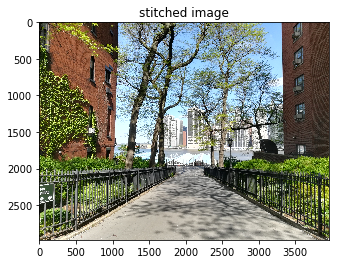

edge[1]=  0
offset=  0
edge[0] is : 0
(372, 496, 3)


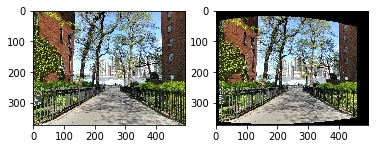

edge[0] is : 0
(372, 496, 3)


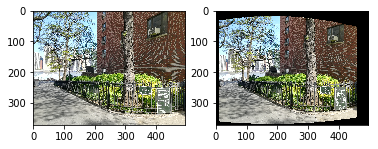

feature points:59


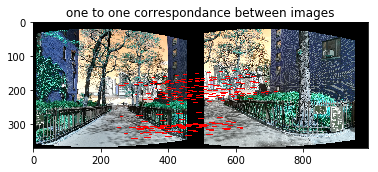

edge[1]=  319
edge[0] is : 250
the shape is : (1372, 996, 3)
(1372, 996, 3)


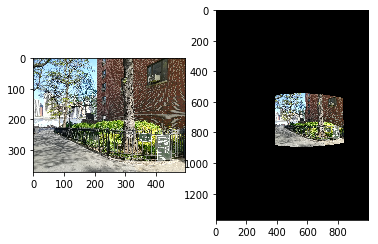

offset=  30
edge[1]=  319
edge[0] is : 0
(402, 556, 3)


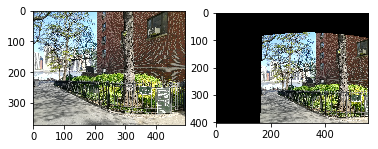

edge[0] is : 0
(402, 556, 3)


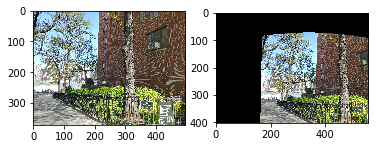

feature points:124


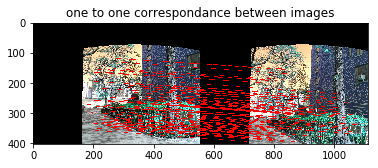

theta -0.9114121989505422 phi -3.4907623554202933
offset=  3
edge[1]=  307
edge[0] is : 0
(375, 502, 3)


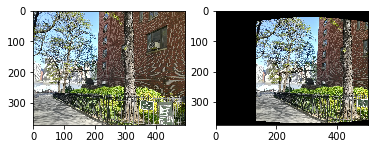

feature points:138


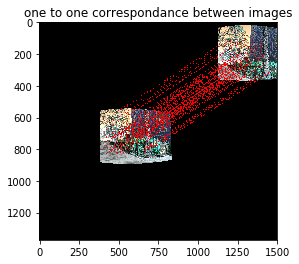

theta 30.960578294352157 phi 58.20538223587873


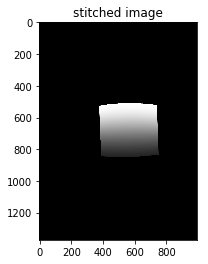

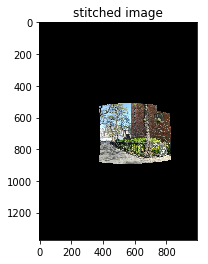

offset=  3
edge[1]=  307
edge[0] is : 0
(375, 502, 3)


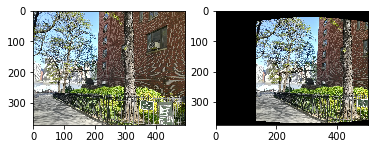

edge[0] is : 0
(375, 502, 3)


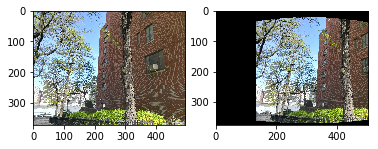

feature points:76


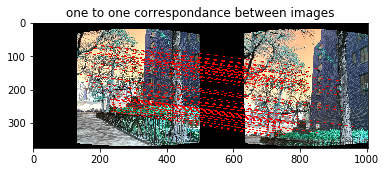

theta -1.4192051626496556 phi -7.3223788094765645
offset=  73
edge[1]=  289
edge[0] is : 0
(445, 642, 3)


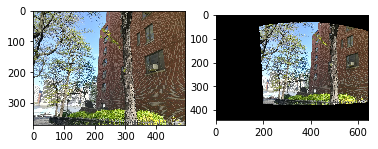

feature points:92


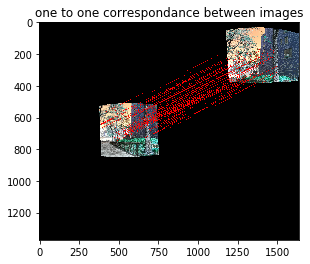

theta 23.074715433827738 phi 51.18130248625515


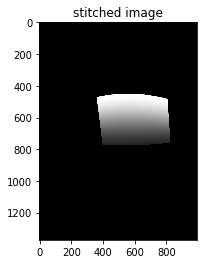

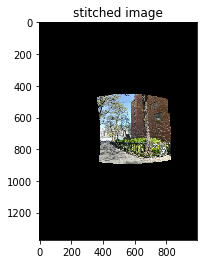

offset=  73
edge[1]=  289
edge[0] is : 0
(445, 642, 3)


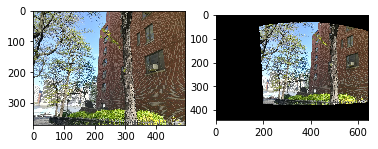

edge[0] is : 0
(445, 642, 3)


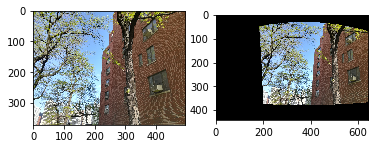

feature points:127


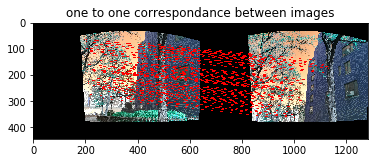

theta -4.866926340492703 phi -6.626957219419331
offset=  137
edge[1]=  226
edge[0] is : 0
(509, 770, 3)


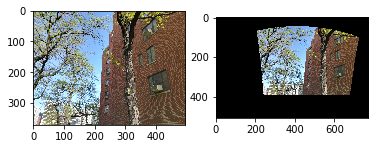

feature points:119


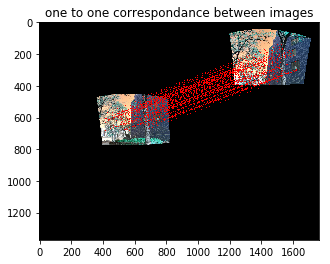

theta 17.102525150182945 phi 44.26388490732899


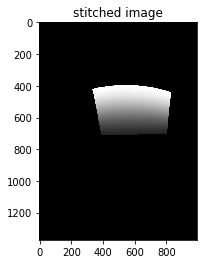

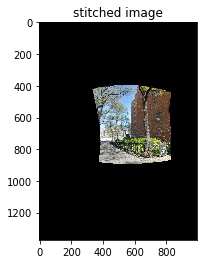

offset=  137
edge[1]=  226
edge[0] is : 0
(509, 770, 3)


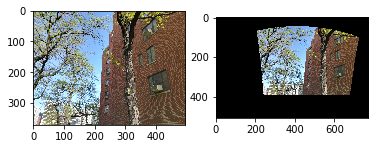

edge[0] is : 0
(509, 770, 3)


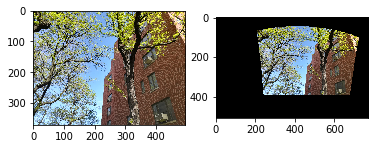

feature points:149


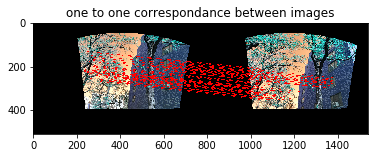

theta -6.303313947071666 phi -7.948879045317392
offset=  213
edge[1]=  145
edge[0] is : 0
(585, 922, 3)


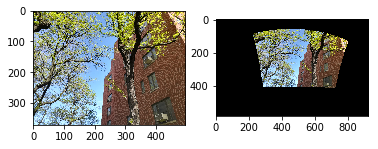

feature points:121


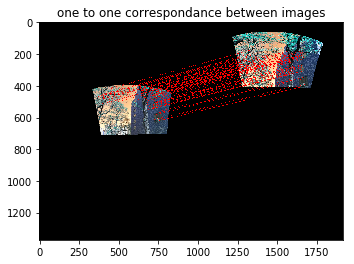

theta 8.78230223117315 phi 35.34445196780089


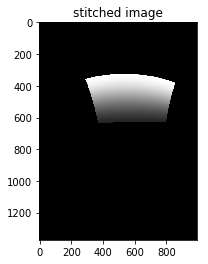

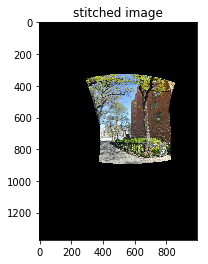

offset=  213
edge[1]=  145
edge[0] is : 0
(585, 922, 3)


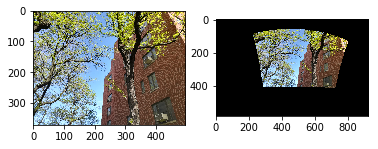

edge[0] is : 0
(585, 922, 3)


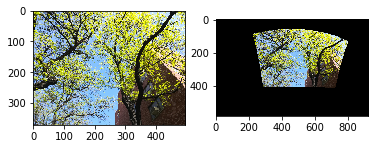

feature points:42


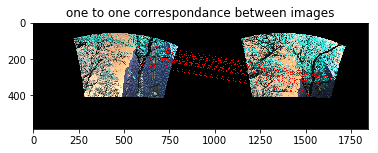

theta -5.052745225330209 phi -28.57293441396092
offset=  487
edge[1]=  79
edge[0] is : 0
(859, 1470, 3)


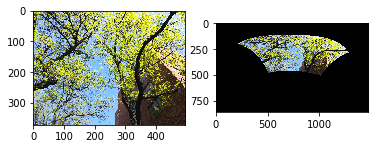

feature points:41


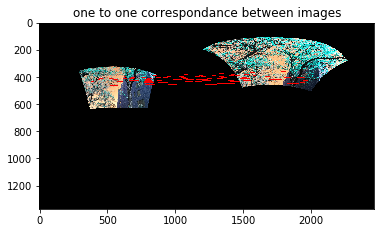

theta -15.693693496985093 phi 17.186385144338033


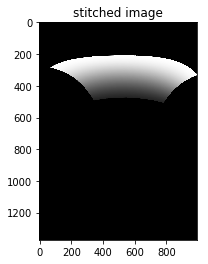

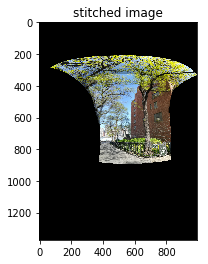

offset=  30
edge[1]=  319
edge[0] is : 0
(402, 556, 3)


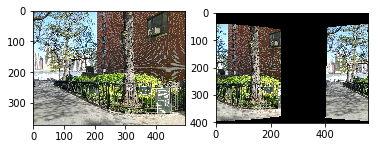

edge[0] is : 0
(402, 556, 3)


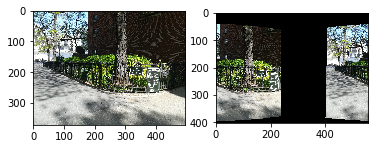

feature points:77


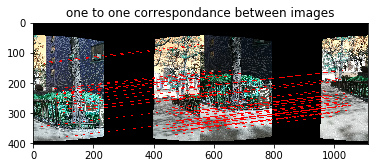

theta 4.859349265547617 phi 7.105273360954564
offset=  98
edge[1]=  382
edge[0] is : 0
(470, 692, 3)


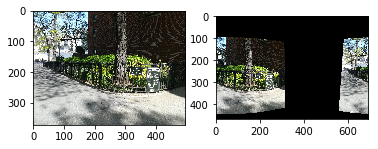

feature points:93


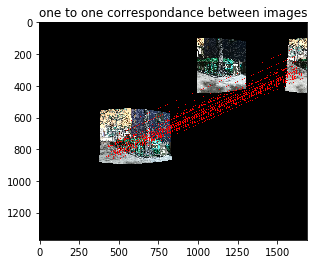

theta -16.137529009784323 phi 58.783284936158594


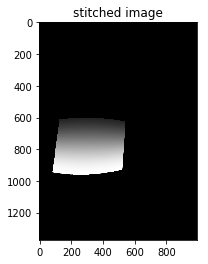

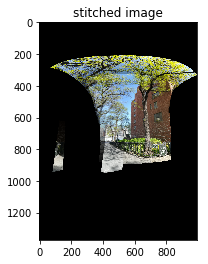

offset=  98
edge[1]=  382
edge[0] is : 0
(470, 692, 3)


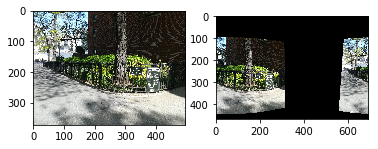

edge[0] is : 0
(470, 692, 3)


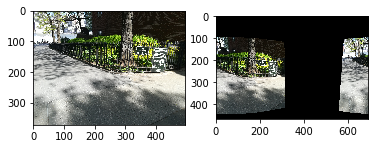

feature points:142


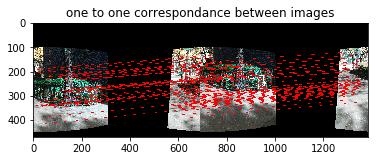

theta -0.2620430130070288 phi 5.845396025299784
offset=  154
edge[1]=  379
edge[0] is : 0
(526, 804, 3)


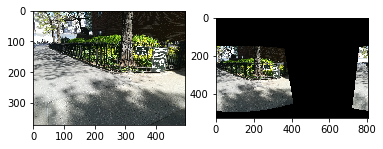

feature points:86


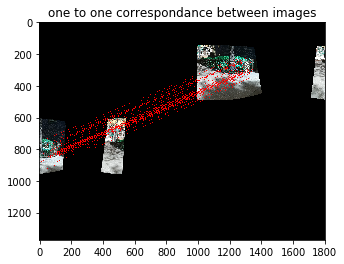

theta -25.234327860307655 phi 59.102457616844866


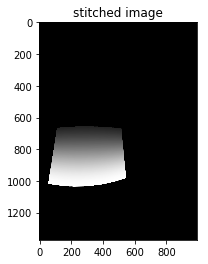

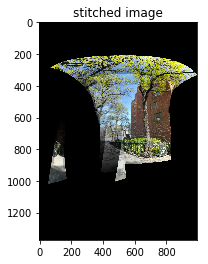

offset=  154
edge[1]=  379
edge[0] is : 0
(526, 804, 3)


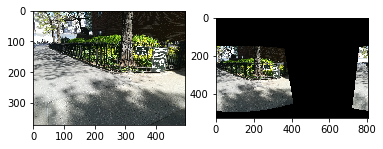

edge[0] is : 0
(526, 804, 3)


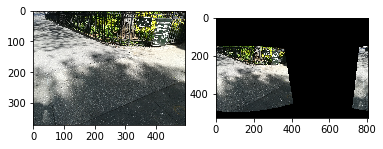

feature points:130


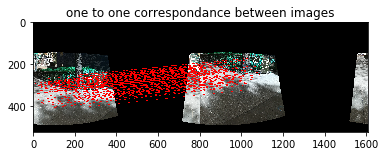

theta -0.050060980424636414 phi 9.729786322251675
offset=  247
edge[1]=  378
edge[0] is : 0
(619, 990, 3)


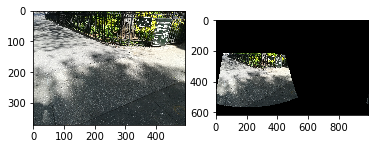

feature points:60


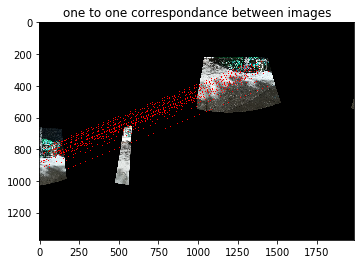

theta -35.708609486991996 phi 59.73408721366431


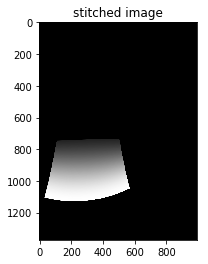

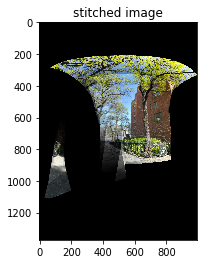

offset=  247
edge[1]=  378
edge[0] is : 0
(619, 990, 3)


In [ ]:
K_down=K/8
K_down[2][2]=1

img_ori = cv2.imread("C:/Users/Yu Shi/Desktop/final_project/360/"+"c0/imgr0.jpg",1)
temp = img_ori
plt.figure()
plt.imshow(cv2.cvtColor(img_ori, cv2.COLOR_BGR2RGB))  #(output * 255).astype(np.uint8)
plt.title('stitched image')
plt.show()
col = 2
outputs = []
theta_i = 0
phi_i=0

for i in range(1,col):
    temp_theta=theta_i
    temp_phi=phi_i
    output,img_i,theta_i,phi_i = horizontalStitching(temp,i,K_down,theta_i,phi_i)
    temp = img_i
    outputs.append(output)
    cv2.imwrite('C:/Users/Yu Shi/Desktop/final_project/360/'+'test/output'+str(i)+'.png',output)


In [94]:
outputs = []
images = glob.glob("C:/Users/Yu Shi/Desktop/final_project/360/outputs/*.png")
for fname in images:
    img_c = cv2.imread(fname,1)
    outputs.append(img_c)
    
result = outputs[0]
results = []
for i in range(1,len(outputs)):
    temp = result
    result,matrix = horizontal_stitching(result,outputs[i])
    cv2.imwrite('C:/Users/Yu Shi/Desktop/final_project/360/results/result'+str(i)+'.png',result)

9


True

502928 [1 1 1] 1347 668


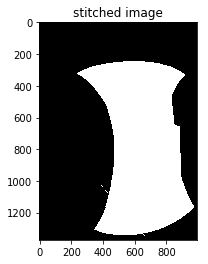

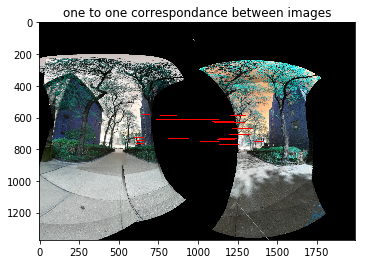

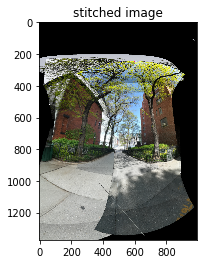

True

In [102]:
col_0 = cv2.imread('output_hor.png',1)
col_1 = cv2.imread('output12.png',1)

output_hor,matrix = horizontal_stitching(col_0,col_1)
cv2.imwrite('output_hor_12.png',output_hor)


# gray1= cv2.cvtColor(col_1,cv2.COLOR_BGR2GRAY)

# (h,w) = gray1.shape

# mask_1 = np.zeros_like(col_1)
# for i in range(h):
#     for j in range(w):
#         if gray1[i][j] != 0:
#             mask_1[i][j]==1
            
            
# warpedImage,matrix = stitching(col_0,col_1,"affine")

# theta_i,phi_i = getThetaAndPhi(matrix,0,0)
# print("theta",theta_i/math.pi*180,"phi",phi_i/math.pi*180)

# mask = cv2.warpAffine(mask_1, matrix, (col_0.shape[1],col_0.shape[0]))


# output = Laplacian_blending(col_0,col_1,mask,levels=4)
# output = output.astype(np.uint8)

# plt.figure()
# plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))  #(output * 255).astype(np.uint8)
# plt.title('stitched image')
# plt.show()


In [76]:
def horizontal_stitching(c1,c2):

    
    gray1= cv2.cvtColor(c1,cv2.COLOR_BGR2GRAY)
    gray2= cv2.cvtColor(c2,cv2.COLOR_BGR2GRAY)


    sift = cv2.xfeatures2d.SIFT_create()

    ################################################ TODO ###############################################
    # use sift.detect to detect features in the images
    kp1 = sift.detect(gray1,None)
    kp2 = sift.detect(gray2,None)

    img1_kps = cv2.drawKeypoints(gray1,kp1,None,flags = cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    img2_kps = cv2.drawKeypoints(gray2,kp2,None,flags = cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    ################################################ TODO ###############################################
    # use sift.compute to generate sift descriptors
    (kp1, features1) = sift.compute(gray1,kp1)
    (kp2, features2) = sift.compute(gray2,kp2)


    kp1 = np.float32([kp.pt for kp in kp1])
    kp2 = np.float32([kp.pt for kp in kp2])

    matcher = cv2.DescriptorMatcher_create("BruteForce")
    ################################################ TODO ###############################################
    # use knnMatch function in matcher to find corresonding features
    rawMatches = matcher.knnMatch(features1,features2,k=2)
    matches = []

    for m in rawMatches:
        # ensure the distance is within a certain ratio of each
        # other (i.e. Lowe's ratio test)
        ################################################ TODO ###############################################
        if len(m) == 2 and m[0].distance<0.7*m[1].distance: # complete the if statement.test the distance between points. use m[0].distance and m[1].distance
            matches.append((m[0].trainIdx, m[0].queryIdx))

    # print(matches)

    ptsA = np.float32([kp1[i] for (_,i) in matches])
    ptsB = np.float32([kp2[i] for (i,_) in matches])

    # print(ptsA)
    ################################################ TODO ###############################################
    ############src-->ptsB, dst------>ptsA
    #affine
    (affineMatrix, status) = cv2.estimateAffine2D(ptsB, ptsA, cv2.RANSAC, ransacReprojThreshold=5.0)
    result = cv2.warpAffine(c2, affineMatrix, (c1.shape[1]+c2.shape[1],c1.shape[0]+c2.shape[0]))
    c1_padded = np.zeros_like(result)
    c1_padded[0:c1.shape[0], 0:c1.shape[1]] = c1

    #homography
    # (H, status) = cv2.findHomography(ptsB,ptsA,cv2.RANSAC) # fill in the parameters 
    # result = cv2.warpPerspective(img2,H,(img1.shape[1] + img2.shape[1], img1.shape[0]))# fill in the arguments to warp the second image to fit the first image.
    # result[0:c1.shape[0], 0:c1.shape[1]] = c1

    output = np.zeros(result.shape)
    #=============================blending=============================
    gray1= cv2.cvtColor(result,cv2.COLOR_BGR2GRAY)
    (h,w) = gray1.shape
    index_i=0
    index_j=0
    num=0
    mask_1 = np.zeros_like(result)
    for i in range(h):
        for j in range(w):
            if gray1[i][j].all() != 0:
                mask_1[i][j][0]=1
                mask_1[i][j][1]=1
                mask_1[i][j][2]=1
                num = num+1
                index_i=i
                index_j=j
    print(num,mask_1[index_i][index_j],index_i,index_j)
                
    plt.figure()
    plt.imshow(cv2.cvtColor((mask_1*255).astype(np.uint8), cv2.COLOR_BGR2RGB))  #(output * 255).astype(np.uint8)
    plt.title('stitched image')
    plt.show()            
    output = Laplacian_blending(result,c1_padded,mask_1,levels=2)
      
    #===================================================================
    output= output.astype(np.uint8)
    # for i in range(x):
    #     for j in range(y):
    #         if c1[i][j]==0 and result[i][j]==0:
    #             output[i][j]=0
    #         elif c1[i][j]==0 and result[i][j]!=0:
    #             output[i][j] = result[i][j]
    #         elif result[i][j]==0 and c1[i][j]!=0:
    #             output[i][j] = (c1[i][j])
    #         else:
    #             output[i][j]= (int(int(c1[i][j]) + int(output[i][j]))/2) 


    vis = drawMatches(c1,c2,kp1,kp2,matches,status)
    plt.figure()
    plt.imshow(vis)
    plt.title('one to one correspondance between images')
    plt.show()

    plt.figure()
    plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))  #(output * 255).astype(np.uint8)
    plt.title('stitched image')
    plt.show()

    return output,affineMatrix

In [24]:
# import the necessary packages
from __future__ import print_function
import numpy as np
import argparse
import cv2
 
def adjust_gamma(image, gamma=1.0):
    # build a lookup table mapping the pixel values [0, 255] to
    # their adjusted gamma values
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255
        for i in np.arange(0, 256)]).astype("uint8")

    # apply gamma correction using the lookup table
    return cv2.LUT(image, table)

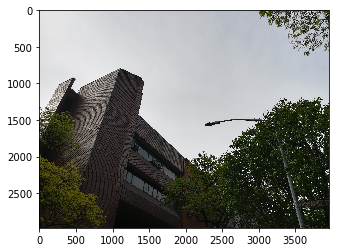

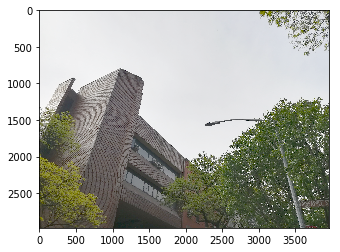

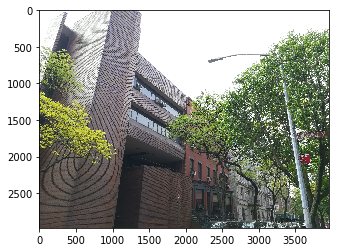

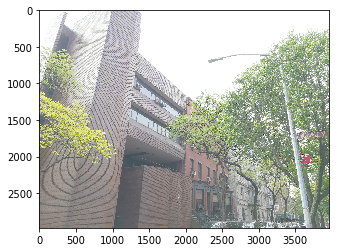

In [37]:

# load the original image
original = cv2.imread("C:/Users/Yu Shi/Desktop/final_project/360/c9/imgr+4.jpg")

adjusted = adjust_gamma(original, gamma=1.0)
plt.figure()
plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))  #(output * 255).astype(np.uint8)
plt.show()
adjusted = adjust_gamma(original, gamma=2)
plt.figure()
plt.imshow(cv2.cvtColor(adjusted, cv2.COLOR_BGR2RGB))  #(output * 255).astype(np.uint8)
plt.show()

original0 = cv2.imread("C:/Users/Yu Shi/Desktop/final_project/360/c9/imgr+2.jpg")

adjusted = adjust_gamma(original0, gamma=1.0)
plt.figure()
plt.imshow(cv2.cvtColor(original0, cv2.COLOR_BGR2RGB))  #(output * 255).astype(np.uint8)
plt.show()
adjusted = adjust_gamma(original0, gamma=2)
plt.figure()
plt.imshow(cv2.cvtColor(adjusted, cv2.COLOR_BGR2RGB))  #(output * 255).astype(np.uint8)
plt.show()
